# Contents:
<blockquote>
1. Reading the Dataset & Selecting 2 classes <br>
2. EDA <br>
3. Data Augmentation <br>
4. Train-Test Split <br>
5. Model Training <br>
6. Fine Tuning the Model <br>
7. Plotting Losses
</blockquote>

In [42]:
# Import the required modules
import datetime
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['font.size'] = 8
from skimage import img_as_float
from skimage import exposure
import plotly.graph_objects as go

import os
import glob
import random
from skimage import io # To preprocess the images
from distutils.file_util import copy_file
import seaborn as sns
import cv2
import keras
from keras.models import load_model
from keras import backend as K
import tensorflow as tf

from skimage.transform import rescale
from keras_preprocessing.image import ImageDataGenerator

import warnings
warnings.simplefilter('ignore')

In [43]:
# Set dataset path

DATASET_PATH = '../input/monkeypox-skin-lesion-dataset/Augmented Images/Augmented Images'

# There are two classes of images that we will deal with
cls = ['Monkeypox_augmented', 'Others_augmented']

# 2. Exploratory Data Analysis

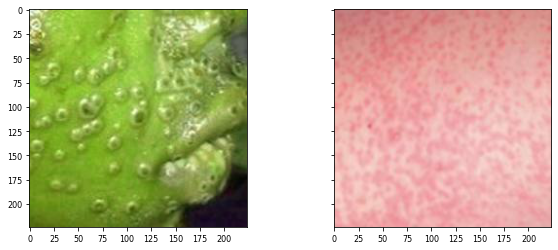

In [44]:
monkeypox_path = os.path.join(DATASET_PATH, cls[0], '*')
monkeypox = glob.glob(monkeypox_path)
monkeypox = io.imread(monkeypox[0])

others_path = os.path.join(DATASET_PATH, cls[1], '*')
others = glob.glob(others_path)
others = io.imread(others[0])

f, axes = plt.subplots(1, 2, sharey=True)
f.set_figwidth(10)

axes[0].imshow(monkeypox, cmap='gray')
axes[1].imshow(others, cmap='gray')

In [45]:
print(f'Image shape for MonkeyPox dataset is: {monkeypox.shape}')
print(f'Image shape for Others dataset is: {others.shape}')

Image shape for MonkeyPox dataset is: (224, 224, 3)
Image shape for Others dataset is: (224, 224, 3)


In [46]:
print(f'Number of MonkeyPox Images: {len(os.listdir(monkeypox_path[:-2]))} \
\nNumber of Others Images: {len(os.listdir(others_path[:-2]))}')

Number of MonkeyPox Images: 1428 
Number of Others Images: 1764


> <strong> This is an Imbalanced Dataset!! </strong>
>
> To deal with this issue, we have applied ***focal loss*** later in the section.

## Preprocessing Images

In [47]:
# Histogram Equalization

def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

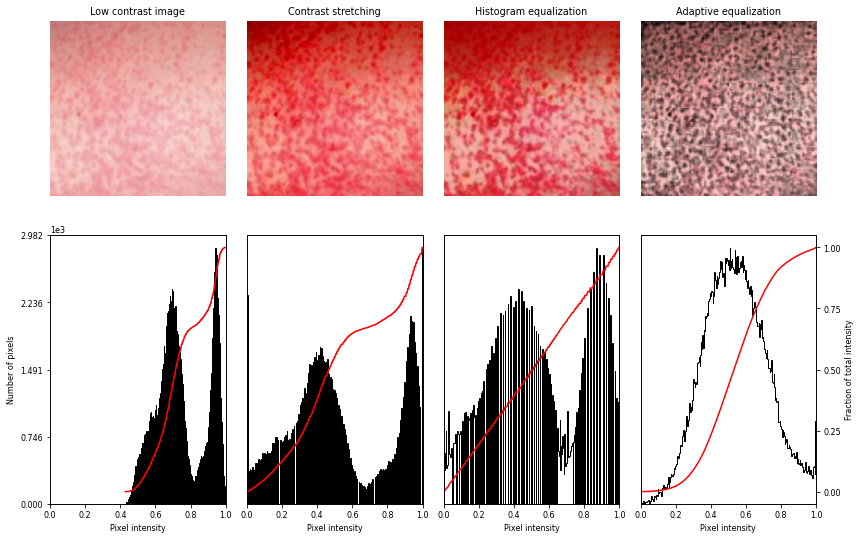

In [48]:
# Load a normal image
img = others

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(12, 8))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

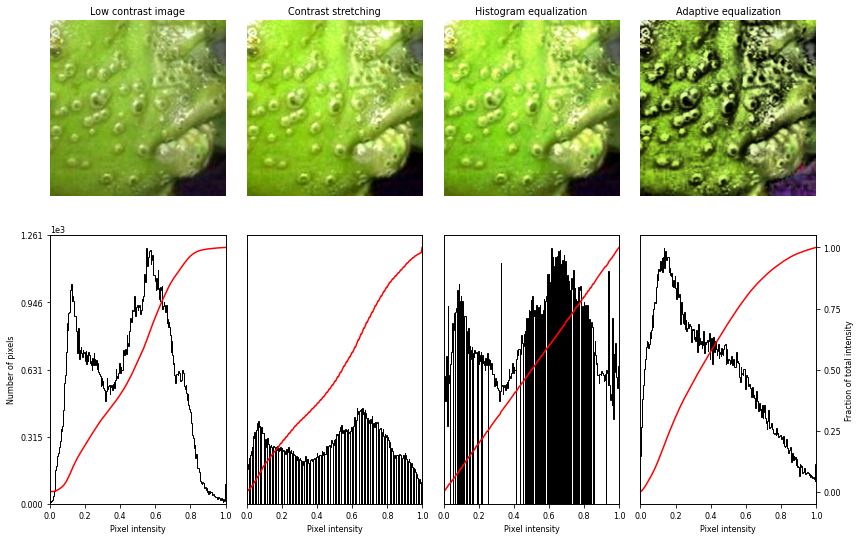

In [49]:
# Load a covid image
img = monkeypox

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(12, 8))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

# 3. Data Augmentation

In [50]:
# Create the list of paths to the images

# Lists for access paths
listMonkeyPoxPaths = []
listOthersPaths = []

# Get covid images files paths
for root, directories, files in os.walk(monkeypox_path[:-2]):
    for name in files:
        listMonkeyPoxPaths.append(os.path.join(root, name))
        
# Get normal images files paths
for root, directories, files in os.walk(others_path[:-2]):
    for name in files:
        listOthersPaths.append(os.path.join(root, name))

# Shuffle lists for random train / test

random.shuffle(listMonkeyPoxPaths)
random.shuffle(listOthersPaths)

# 4. Train-Test Split

In [51]:
# Create new folders for image training

# main folder
!mkdir ./Data/

# Train data folders
!mkdir ./Data/Train/
!mkdir ./Data/Train/MonkeyPox/
!mkdir ./Data/Train/Others/

# Test data folders
!mkdir ./Data/Test/
!mkdir ./Data/Test/MonkeyPox/
!mkdir ./Data/Test/Others/

# Paths to MonkeyPox images folders
pathMonkeyPoxTrain = './Data/Train/MonkeyPox/'
pathMonkeyPoxTest = './Data/Test/MonkeyPox/'

# Paths to others images folders
pathOthersTrain = './Data/Train/Others/'
pathOthersTest = './Data/Test/Others/'

mkdir: cannot create directory ‘./Data/’: File exists
mkdir: cannot create directory ‘./Data/Train/’: File exists
mkdir: cannot create directory ‘./Data/Train/MonkeyPox/’: File exists
mkdir: cannot create directory ‘./Data/Train/Others/’: File exists
mkdir: cannot create directory ‘./Data/Test/’: File exists
mkdir: cannot create directory ‘./Data/Test/MonkeyPox/’: File exists
mkdir: cannot create directory ‘./Data/Test/Others/’: File exists


In [52]:
# Move files to new folders in the 80:20 ratio

len_monkeypox = len(os.listdir(monkeypox_path[:-2]))
len_others = len(os.listdir(others_path[:-2]))
monkeypox_80 = round(len(os.listdir(monkeypox_path[:-2])) * 0.8)     # 80% of the monkeypox data
others_80 = round(len(os.listdir(others_path[:-2])) * 0.8)   # 80% of the others data

# Move monkeypox images files to new folders
for i in range(len_monkeypox):
    if i < monkeypox_80:
        copy_file(listMonkeyPoxPaths[i], pathMonkeyPoxTrain)
    else : 
        copy_file(listMonkeyPoxPaths[i], pathMonkeyPoxTest)

# Move normal images files to new folders
for i in range(len_others):
    if i < others_80:
        copy_file(listOthersPaths[i], pathOthersTrain)
    else:
        copy_file(listOthersPaths[i], pathOthersTest)

In [53]:
# Definition of data generators

# for train data
trainGenerator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    zoom_range = 0.2,
    shear_range = 0.2,
    featurewise_center = True,
    featurewise_std_normalization = True,
    width_shift_range = 0,
    height_shift_range = 0,
    vertical_flip = False,
    fill_mode = 'nearest'
)

# for test data
testGenerator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,    
)

In [54]:
# Build data generators

# Build for train data
pathTrainDir = './Data/Train/'

trainGeneratorBuild = trainGenerator.flow_from_directory(
    pathTrainDir,
    target_size = (224, 224),
    class_mode = 'binary',
    batch_size = 16,
    shuffle = True 
)

# Build for test data
pathTestDir = './Data/Test/'

testGeneratorBuild = testGenerator.flow_from_directory(
    pathTestDir,
    target_size = (224, 224),
    class_mode = 'binary',
    batch_size = 16,
    shuffle = True
)

Found 3052 images belonging to 2 classes.
Found 1138 images belonging to 2 classes.


# 5. Model Traning

## Train Model from Scratch

In [55]:
# MonkeyPox and Normal dataset directory
BASIS_DIR = '../input/monkeypox-skin-lesion-dataset/Augmented Images/Augmented Images'
CLASSES = ["Monkeypox_augmented",  "Others_augmented"]

In [56]:
#Image augmentation process:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    horizontal_flip = True,
    vertical_flip = False,
    shear_range = 0.2,
    zoom_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    fill_mode = 'nearest',
    
    #split dataset to training(80%) and validation(20%):
    validation_split = 0.2
)

In [57]:
# Training dataset and Validation dataset:
train_data = train_datagen.flow_from_directory(
    directory=BASIS_DIR,
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    class_mode='binary',
    subset='training',
    classes=CLASSES
    )
val_data = train_datagen.flow_from_directory(
    directory=BASIS_DIR,
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    class_mode='binary',
    subset='validation',
    classes=CLASSES
    )

Found 2555 images belonging to 2 classes.
Found 637 images belonging to 2 classes.


## Train Model using Trasfer Learning

In [67]:
# Define the Keras model
# Use InceptionResNetV2 Keras model

# engine = tf.keras.applications.InceptionResNetV2(
engine = tf.keras.applications.InceptionResNetV2(
    
    # Freezing the weights of the top layer in the InceptionResNetV2 pre-traiined model
    include_top = False,

    # Use Imagenet weights
    weights = 'imagenet',

    # Define input shape to 224x224x3
    input_shape = (224, 224, 3),
    classes=2,

    # Set classifier activation to sigmoid
#     classifier_activation='softmax'
)

94781440/94765736 [==============================] - 0s 0us/step


In [68]:
# Define the Keras model outputs

x = tf.keras.layers.GlobalAveragePooling2D(name = 'avg_pool')(engine.output)
out = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'dense_output')(x)


# Build the Keras model

model = tf.keras.models.Model(inputs = engine.input, outputs = out)


### (i) Loss: binary_crossentropy

In [69]:
# Compile the model
# METRICS = [
#         'accuracy',
#         tf.keras.metrics.Precision(name='precision'),
#         tf.keras.metrics.Recall(name='recall')
#     ]
model.compile(
    # Set optimizer to Adam(0.001)
    optimizer = tf.keras.optimizers.Adam(0.001),

    # Set loss to binary crossentropy
    loss = 'binary_crossentropy',

    # Set metrics to accuracy
    metrics = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

In [70]:
# Fit Keras model

number_epochs=12
history = model.fit_generator(
    # Use train generator
    trainGeneratorBuild,

    # Set epochs to 12
    epochs = number_epochs, 

    # Set steps per epochs to 300
#     steps_per_epoch = 300,
    
    # Set verbose to 1
    verbose = 1
)

end = datetime.datetime.now()
print(f'Total Training Time: {end - start}')

Epoch 1/12
191/191 [==============================] - 46s 213ms/step - loss: 0.7213 - accuracy: 0.6799 - precision: 0.6739 - recall: 0.8114
Epoch 2/12
191/191 [==============================] - 41s 214ms/step - loss: 0.5746 - accuracy: 0.7221 - precision: 0.7096 - recall: 0.8388
Epoch 3/12
191/191 [==============================] - 42s 217ms/step - loss: 0.5582 - accuracy: 0.7451 - precision: 0.7312 - recall: 0.8495
Epoch 4/12
191/191 [==============================] - 41s 214ms/step - loss: 0.5142 - accuracy: 0.7549 - precision: 0.7426 - recall: 0.8495
Epoch 5/12
191/191 [==============================] - 40s 211ms/step - loss: 0.4543 - accuracy: 0.8021 - precision: 0.7967 - recall: 0.8602
Epoch 6/12
191/191 [==============================] - 41s 212ms/step - loss: 0.3786 - accuracy: 0.8342 - precision: 0.8212 - recall: 0.8935
Epoch 7/12
191/191 [==============================] - 40s 211ms/step - loss: 0.3618 - accuracy: 0.8473 - precision: 0.8377 - recall: 0.8965
Epoch 8/12
191/191 [

In [71]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'precision', 'recall'])


In [72]:
model.save('my_model_2.h5')

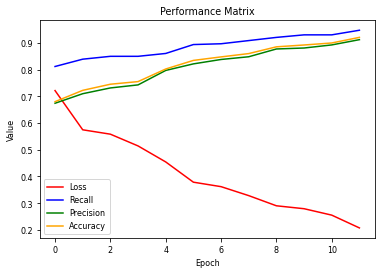

In [73]:
# Plot training accuracy and validation accuracy


plt.plot(history.history['loss'], 'r', label='Loss')
plt.plot(history.history['recall'], 'b', label='Recall')
plt.plot(history.history['precision'], 'g', label='Precision')
plt.plot(history.history['accuracy'], 'orange', label='Accuracy')

plt.title('Performance Matrix')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.show()

In [74]:
# Create a graph representing the loss

# Get loss data
lossG = history.history['loss']
accuracyG = history.history['accuracy']
epochs = [i for i in range(len(lossG))]

# Create graph
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = epochs,
        y = lossG,
        name = 'Loss',
        marker = dict(
            color = 'rgba(250,50,50,1)'        
        )
    )
)

fig.add_trace(
    go.Scatter(
        x = epochs,
        y = accuracyG,
        name = 'Accuracy',
        marker = dict(
            color = 'rgba(50,250,50,1)'        
        )
    )
)

fig.update_layout(
    title = 'Model loss',
    template = 'plotly_white'
)

fig.update_xaxes(
    title_text='Epochs'
)
fig.update_yaxes(
    title_text='Loss / Accuracy values'
)

fig.show()

72/72 [==============================] - 4s 40ms/step - loss: 3.1836 - accuracy: 0.5650 - precision: 0.9507 - recall: 0.2167
Accuracy of model : 21.67 %
Precision of model : 318.36 %
Recall of model : 56.49999999999999 %
Loss of model : 0.9507


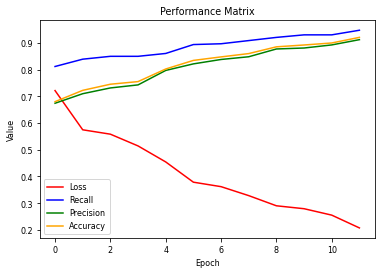

In [75]:
# # Checke the accuracy of the Keras model on the test data

testPrecision, testRecall, testLoss, testAccuracy = model.evaluate(
    # Use test generator
    testGeneratorBuild,
    
    # Set verbose to 1
    verbose = 1
)



# Print results
print('Accuracy of model : ' + str(round(testAccuracy,4)*100) + ' %')
print('Precision of model : ' + str(round(testPrecision,4)*100) + ' %')
print('Recall of model : ' + str(round(testRecall,4)*100) + ' %')
print('Loss of model : ' + str(round(testLoss,4)))

# Plot training accuracy and validation accuracy


plt.plot(history.history['loss'], 'r', label='Loss')
plt.plot(history.history['recall'], 'b', label='Recall')
plt.plot(history.history['precision'], 'g', label='Precision')
plt.plot(history.history['accuracy'], 'orange', label='Accuracy')

plt.title('Performance Matrix')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.show()

# 6. Fine Tuning the Model

In [76]:
# Define our custom loss function

def focal_loss(y_true, y_pred):
    gamma = 0.22
    alpha = 0.1
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))


In [77]:
# Compile our model
METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
adam = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', metrics=METRICS, optimizer=adam)

In [78]:
# Fit Keras model
# start = datetime.datetime.now()

history = model.fit_generator(
    # Use train generator
    trainGeneratorBuild,

    # Set epochs to 20
    epochs = 20,

    # Set steps per epochs to 300
#     steps_per_epoch = 300,       # batch_size

    # Set verbose to 1
    verbose = 1
)

# end = datetime.datetime.now()
# print(f'Total Training Time: {end - start}')

Epoch 1/20
191/191 [==============================] - 47s 211ms/step - loss: 0.1299 - accuracy: 0.9531 - precision: 0.9481 - recall: 0.9679
Epoch 2/20
191/191 [==============================] - 41s 214ms/step - loss: 0.0964 - accuracy: 0.9659 - precision: 0.9630 - recall: 0.9756
Epoch 3/20
191/191 [==============================] - 40s 208ms/step - loss: 0.0817 - accuracy: 0.9705 - precision: 0.9671 - recall: 0.9798
Epoch 4/20
191/191 [==============================] - 41s 213ms/step - loss: 0.0759 - accuracy: 0.9741 - precision: 0.9717 - recall: 0.9816
Epoch 5/20
191/191 [==============================] - 40s 210ms/step - loss: 0.0670 - accuracy: 0.9758 - precision: 0.9718 - recall: 0.9845
Epoch 6/20
191/191 [==============================] - 40s 211ms/step - loss: 0.0597 - accuracy: 0.9780 - precision: 0.9764 - recall: 0.9839
Epoch 7/20
191/191 [==============================] - 39s 206ms/step - loss: 0.0471 - accuracy: 0.9853 - precision: 0.9829 - recall: 0.9905
Epoch 8/20
191/191 [

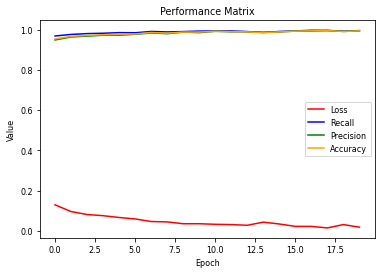

In [79]:
# Plot training accuracy and validation accuracy


plt.plot(history.history['loss'], 'r', label='Loss')
plt.plot(history.history['recall'], 'b', label='Recall')
plt.plot(history.history['precision'], 'g', label='Precision')
plt.plot(history.history['accuracy'], 'orange', label='Accuracy')

plt.title('Performance Matrix')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.show()

In [80]:
model.save('my_model_3.h5')

# 7. Plot Loss

In [81]:
# Create a graph representing the loss

# Get loss data
lossG = history.history['loss']
accuracyG = history.history['accuracy']
epochs = [i for i in range(len(lossG))]

# Create graph
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = epochs,
        y = lossG,
        name = 'Loss',
        marker = dict(
            color = 'rgba(250,50,50,1)'        
        )
    )
)

fig.add_trace(
    go.Scatter(
        x = epochs,
        y = accuracyG,
        name = 'Accuracy',
        marker = dict(
            color = 'rgba(50,250,50,1)'        
        )
    )
)

fig.update_layout(
    title = 'Model loss',
    template = 'plotly_white'
)

fig.update_xaxes(
    title_text='Epochs'
)
fig.update_yaxes(
    title_text='Loss / Accuracy values'
)

fig.show()

72/72 [==============================] - 4s 38ms/step - loss: 0.0116 - accuracy: 0.9974 - precision: 0.9952 - recall: 1.0000
Accuracy of model : 100.0 %
Precision of model : 1.16 %
Recall of model : 99.74 %
Loss of model : 0.9952


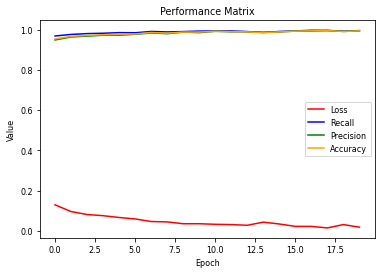

In [82]:
# # Checke the accuracy of the Keras model on the test data

testPrecision, testRecall, testLoss, testAccuracy = model.evaluate(
    # Use test generator
    testGeneratorBuild,
    
    # Set verbose to 1
    verbose = 1
)



# Print results
print('Accuracy of model : ' + str(round(testAccuracy,4)*100) + ' %')
print('Precision of model : ' + str(round(testPrecision,4)*100) + ' %')
print('Recall of model : ' + str(round(testRecall,4)*100) + ' %')
print('Loss of model : ' + str(round(testLoss,4)))

# Plot training accuracy and validation accuracy


plt.plot(history.history['loss'], 'r', label='Loss')
plt.plot(history.history['recall'], 'b', label='Recall')
plt.plot(history.history['precision'], 'g', label='Precision')
plt.plot(history.history['accuracy'], 'orange', label='Accuracy')

plt.title('Performance Matrix')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.show()